In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import random

In [ ]:
random.seed(760)

In [ ]:
data=pd.read_csv('drive/MyDrive/clean_data.csv', encoding='utf-8')
def get_season(month): #春0夏1秋2冬3
    if 9 <= month <= 11:
        return "0"
    elif 12 <= month <= 2:
        return "1"
    elif 3 <= month <= 6:
        return "2"
    else:
        return "3"
data['Date'] = pd.to_datetime(data['Date'])
data['season'] = data['Date'].dt.month.apply(get_season)
grouped_data = data.groupby("Date")["Victimisations"].sum().reset_index()
grouped_data['season'] = data.groupby("Date")['season'].first().reset_index()['season']

In [ ]:
train_data = grouped_data[grouped_data['Date'] < '2021-01-01']
test_data = grouped_data[grouped_data['Date'] >= '2021-01-01']

In [ ]:
scaler = MinMaxScaler()
grouped_data_scaled = scaler.fit_transform(grouped_data[['Victimisations', 'season']])
train_data_scaled = grouped_data_scaled[grouped_data['Date'] < '2021-01-01']
test_data_scaled = grouped_data_scaled[grouped_data['Date'] >= '2021-01-01']

In [ ]:
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 3
X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)

In [ ]:
model = Sequential()
model.add(LSTM(150,return_sequences=True,input_shape=(window_size, 2)))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(X_train, y_train, epochs=200, batch_size=4,validation_split=0.15,callbacks=[early_stop])

Epoch 1/200
14/14 [==============================] - 20s 393ms/step - loss: 0.0929 - val_loss: 0.1069
Epoch 2/200
14/14 [==============================] - 1s 47ms/step - loss: 0.0151 - val_loss: 0.0463
Epoch 3/200
14/14 [==============================] - 1s 46ms/step - loss: 0.0094 - val_loss: 0.0536
Epoch 4/200
14/14 [==============================] - 1s 39ms/step - loss: 0.0042 - val_loss: 0.0513
Epoch 5/200
14/14 [==============================] - 0s 32ms/step - loss: 0.0031 - val_loss: 0.0462
Epoch 6/200
14/14 [==============================] - 1s 47ms/step - loss: 0.0039 - val_loss: 0.0539
Epoch 7/200
14/14 [==============================] - 1s 37ms/step - loss: 0.0039 - val_loss: 0.0482
Epoch 8/200
14/14 [==============================] - 0s 28ms/step - loss: 0.0039 - val_loss: 0.0510
Epoch 9/200
14/14 [==============================] - 0s 32ms/step - loss: 0.0041 - val_loss: 0.0480
Epoch 10/200
14/14 [==============================] - 0s 31ms/step - loss: 0.0039 - val_loss: 0.05

In [ ]:
predicted = model.predict(X_test)
predicted_transformed = scaler.inverse_transform(np.concatenate([np.reshape(predicted, (-1, 1)), np.zeros((len(predicted), 1))], axis=1))[:, 0]
y_test_transformed = scaler.inverse_transform(np.concatenate([np.reshape(y_test, (-1, 1)), np.zeros((len(y_test), 1))], axis=1))[:, 0]

1/1 [==============================] - 4s 4s/step


In [ ]:
mse = mean_squared_error(y_test_transformed, predicted_transformed)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 4760357.911011727


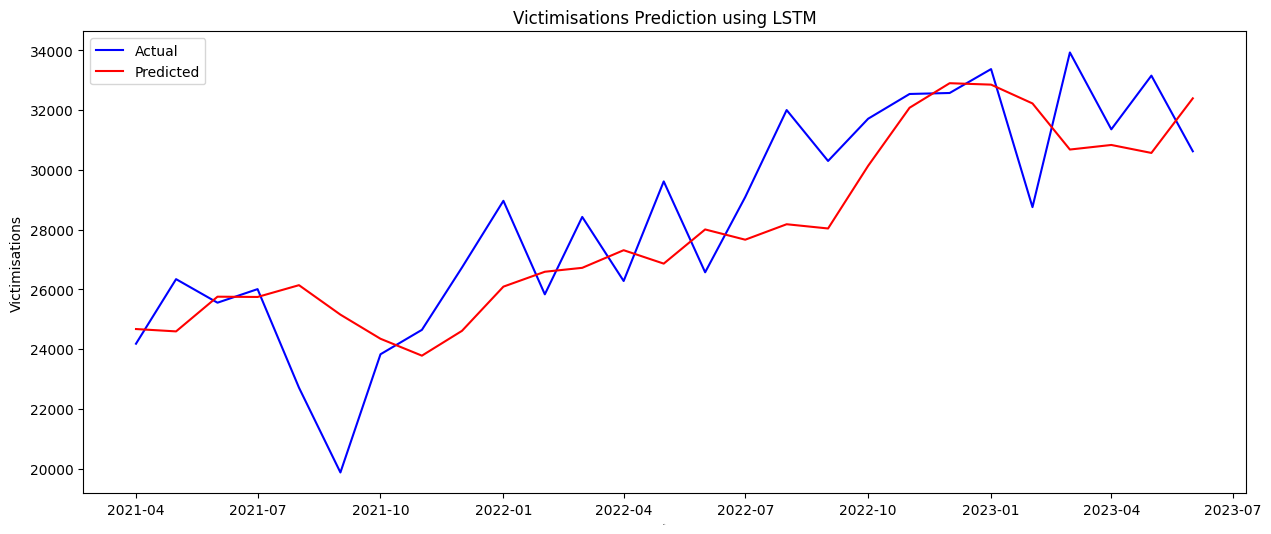

In [ ]:
time_axis = test_data['Date'][window_size:]
plt.figure(figsize=(15, 6))
plt.plot(time_axis, y_test_transformed, label='Actual', color='blue')
plt.plot(time_axis, predicted_transformed, label='Predicted', color='red')
plt.xlabel('Date', fontsize=0.1)
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction using LSTM')
plt.legend()
plt.show()

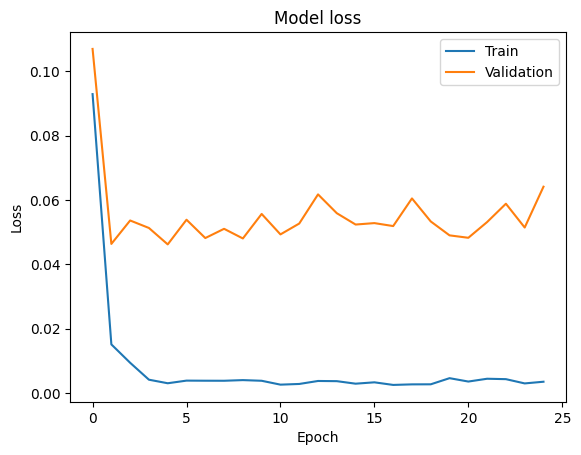

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

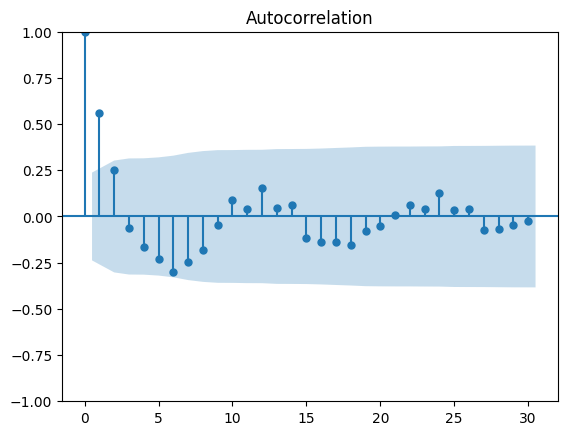

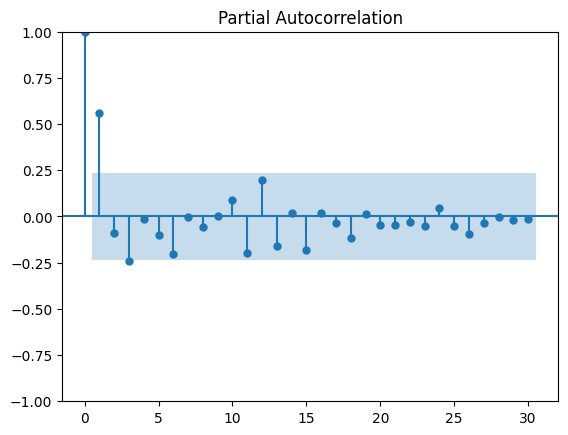

In [ ]:
plot_acf(train_data['Victimisations'],lags=30)
plt.show()
plot_pacf(train_data['Victimisations'],lags=30)
plt.show()

In [ ]:
model = SARIMAX(train_data['Victimisations'], order=(1,0,2), seasonal_order=(1,0,1,12))
model_fit = model.fit()
predictions_ARIMA = model_fit.forecast(steps=len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


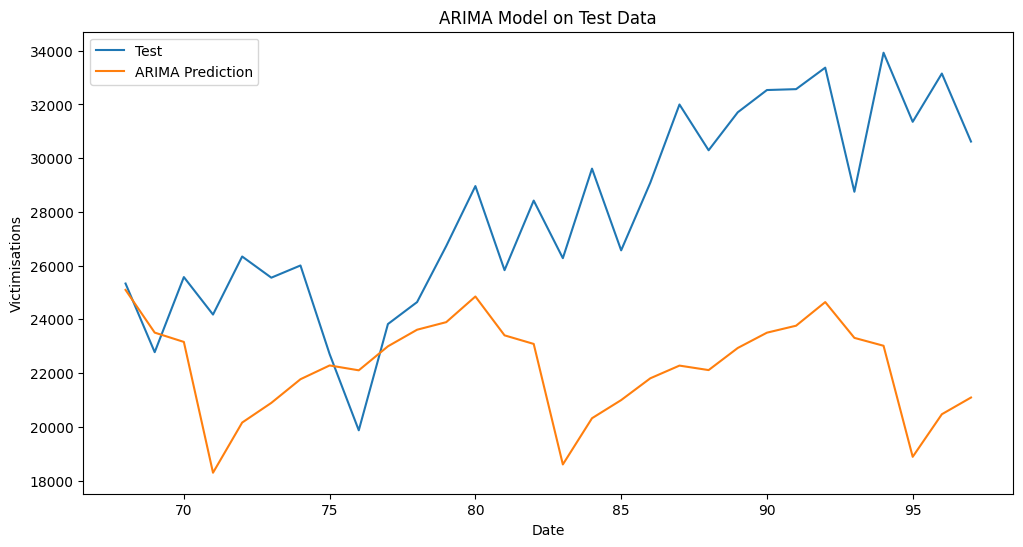

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Victimisations'], label='Test')
plt.plot(test_data.index, predictions_ARIMA, label='ARIMA Prediction')
plt.title("ARIMA Model on Test Data")
plt.xlabel("Date")
plt.ylabel("Victimisations")
plt.legend()
plt.show()

In [ ]:
residuals = train_data['Victimisations'] - model_fit.fittedvalues
residuals

0     21250.000000
1       -58.973137
2       296.767977
3        -1.242971
4      -580.971860
          ...     
63     -973.415513
64      114.095920
65     -174.149017
66      352.225807
67       51.809366
Length: 68, dtype: float64

In [ ]:
scaler = MinMaxScaler()
residuals_with_season = pd.DataFrame({'residuals': residuals, 'season': train_data['season']})
residuals_with_season_scaled = scaler.fit_transform(residuals_with_season)
window_size = 3
X_train_res, y_train_res = create_dataset(residuals_with_season_scaled, window_size)
model_res = Sequential()
model_res.add(LSTM(200, return_sequences=True, input_shape=(window_size, 2)))
model_res.add(LSTM(150))
model_res.add(Dropout(0.1))
model_res.add(Dense(1))
model_res.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=20)
history_res = model_res.fit(X_train_res, y_train_res, epochs=200, batch_size=4, validation_split=0.15, callbacks=[early_stop])



Epoch 1/200
14/14 [==============================] - 5s 113ms/step - loss: 0.0262 - val_loss: 0.0226
Epoch 2/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0060 - val_loss: 0.0153
Epoch 3/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0032 - val_loss: 0.0125
Epoch 4/200
14/14 [==============================] - 0s 29ms/step - loss: 0.0027 - val_loss: 0.0100
Epoch 5/200
14/14 [==============================] - 0s 29ms/step - loss: 0.0022 - val_loss: 0.0105
Epoch 6/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0021 - val_loss: 0.0141
Epoch 7/200
14/14 [==============================] - 0s 26ms/step - loss: 0.0020 - val_loss: 0.0104
Epoch 8/200
14/14 [==============================] - 0s 29ms/step - loss: 0.0024 - val_loss: 0.0094
Epoch 9/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 0.0135
Epoch 10/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0019 - val_loss: 0.010

In [ ]:
predicted_res = model_res.predict(X_test)
zero_col = np.zeros((predicted_res.shape[0], 1))
predicted_res_with_zero_col = np.hstack([predicted_res, zero_col])
predicted_res_transformed = scaler.inverse_transform(predicted_res_with_zero_col)
predicted_res_transformed_1D = predicted_res_transformed[:, 0]
min_length = min(len(predictions_ARIMA), len(predicted_res_transformed_1D))
predicted_res_transformed = -predicted_res_transformed
final_prediction = predictions_ARIMA[:min_length] + predicted_res_transformed_1D[:min_length]


1/1 [==============================] - 1s 773ms/step


In [ ]:
mse2 = mean_squared_error(y_test_transformed, final_prediction)
print(f'Mean Squared Error: {mse2}')

Mean Squared Error: 17870465.222363237


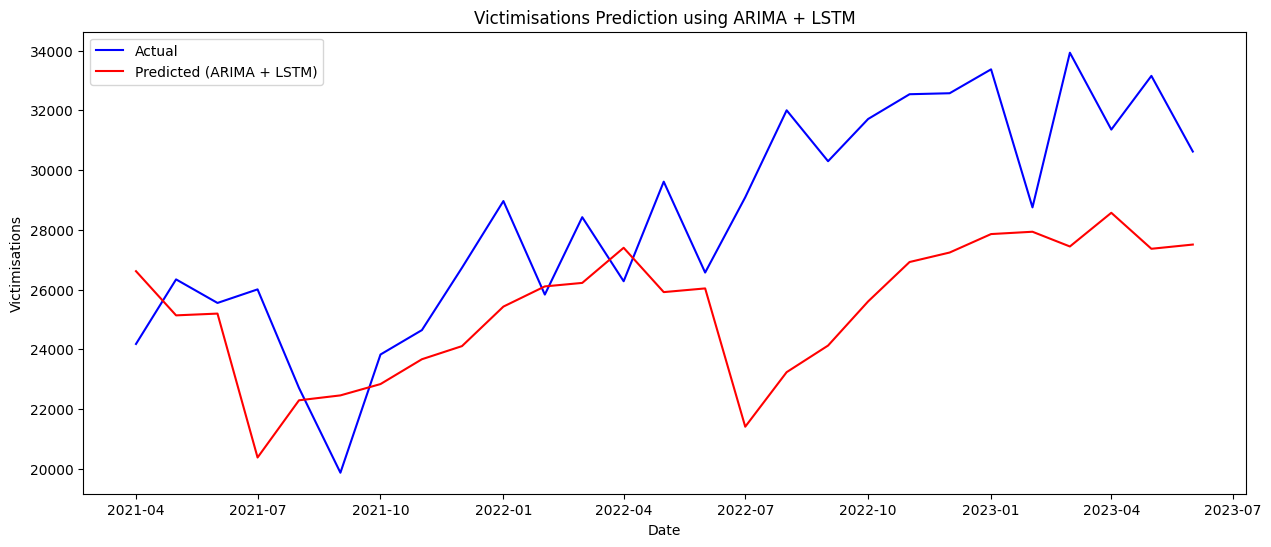

In [ ]:
min_length = min(len(time_axis), len(final_prediction))
time_axis = time_axis[:min_length]
final_prediction = final_prediction[:min_length]
plt.figure(figsize=(15, 6))
plt.plot(time_axis, y_test_transformed[:min_length], label='Actual', color='blue')
plt.plot(time_axis, final_prediction, label='Predicted (ARIMA + LSTM)', color='red')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction using ARIMA + LSTM')
plt.legend()
plt.show()


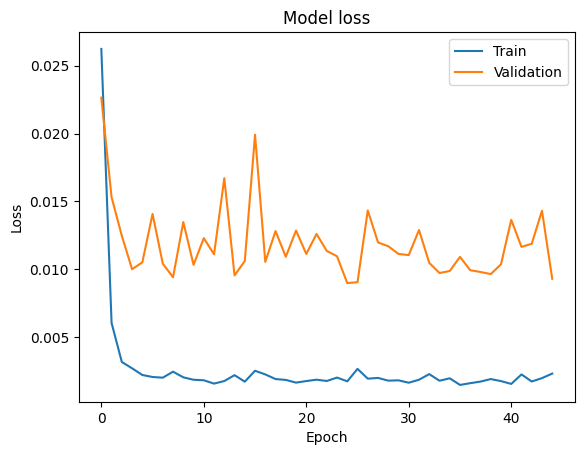

In [ ]:
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
selected_age = ['Teenagers', 'Middle-aged-young', 'Middle-aged-old', 'Elderly']
filtered_data = data[data['Age Group'].isin(selected_age)]
crime_counts_by_age = filtered_data.groupby(['Date', 'Age Group'])['Victimisations'].sum().reset_index()

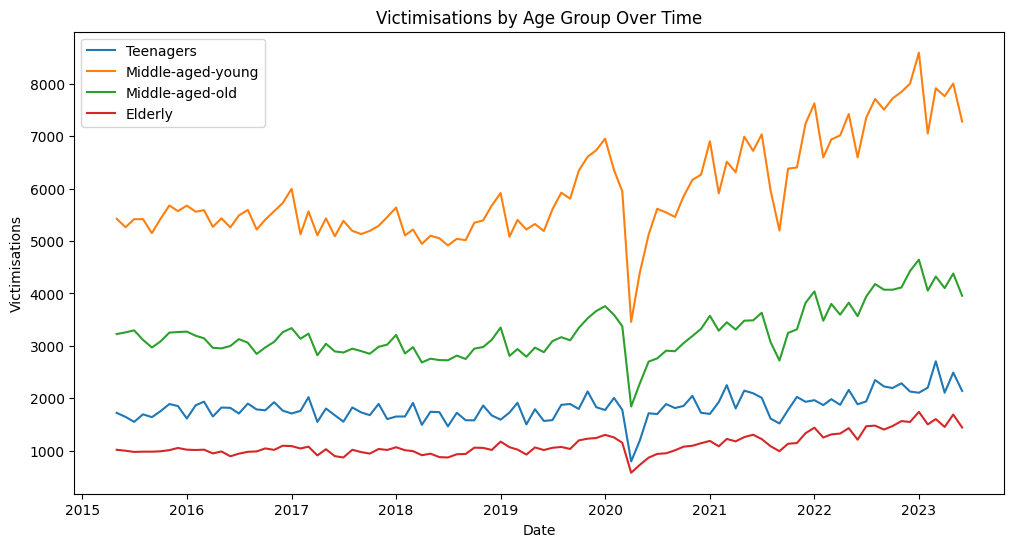

In [ ]:
crime_counts_by_age['Date'] = pd.to_datetime(crime_counts_by_age['Date'])
crime_counts_by_age.sort_values(['Date', 'Age Group'], inplace=True)
plt.figure(figsize=(12, 6))
for age_group in selected_age:
    subset = crime_counts_by_age[crime_counts_by_age['Age Group'] == age_group]
    plt.plot(subset['Date'], subset['Victimisations'], label=age_group)

plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations by Age Group Over Time')
plt.legend()
plt.show()

In [ ]:
selected_ethnicities = ['Asian', 'European', 'Indian', 'Maori', 'Pacific Island']
filtered_data = data[data['Ethnic Group'].isin(selected_ethnicities)]
crime_counts_by_ethnicity = filtered_data.groupby(['Date', 'Ethnic Group'])['Victimisations'].sum().reset_index()
crime_counts_by_ethnicity


,Date,Ethnic Group,Victimisations
0,2015-05-01,Asian,578
1,2015-05-01,European,4758
2,2015-05-01,Indian,548
3,2015-05-01,Maori,1953
4,2015-05-01,Pacific Island,562
...,...,...,...
485,2023-06-01,Asian,525
486,2023-06-01,European,4549
487,2023-06-01,Indian,664
488,2023-06-01,Maori,3093


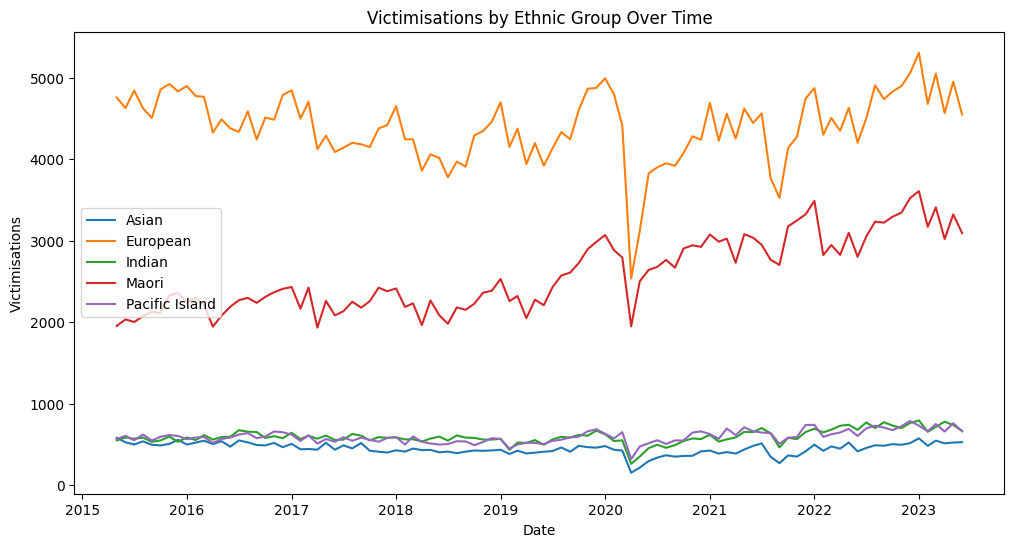

In [ ]:
crime_counts_by_ethnicity['Date'] = pd.to_datetime(crime_counts_by_ethnicity['Date'])
crime_counts_by_ethnicity.sort_values(['Date', 'Ethnic Group'], inplace=True)
plt.figure(figsize=(12, 6))
for ethnicity in selected_ethnicities:
    subset = crime_counts_by_ethnicity[crime_counts_by_ethnicity['Ethnic Group'] == ethnicity]
    plt.plot(subset['Date'], subset['Victimisations'], label=ethnicity)

plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations by Ethnic Group Over Time')
plt.legend()
plt.show()


Epoch 1/200
14/14 [==============================] - 7s 123ms/step - loss: 0.2172 - val_loss: 0.1361
Epoch 2/200
14/14 [==============================] - 0s 19ms/step - loss: 0.0251 - val_loss: 0.0953
Epoch 3/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0184 - val_loss: 0.1049
Epoch 4/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0114 - val_loss: 0.0937
Epoch 5/200
14/14 [==============================] - 0s 18ms/step - loss: 0.0113 - val_loss: 0.0997
Epoch 6/200
14/14 [==============================] - 0s 18ms/step - loss: 0.0111 - val_loss: 0.0920
Epoch 7/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0122 - val_loss: 0.1041
Epoch 8/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0107 - val_loss: 0.0920
Epoch 9/200
14/14 [==============================] - 0s 18ms/step - loss: 0.0114 - val_loss: 0.0961
Epoch 10/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0115 - val_loss: 0.095

1/1 [==============================] - 1s 793ms/step
Epoch 1/200
14/14 [==============================] - 7s 248ms/step - loss: 0.1760 - val_loss: 0.1285
Epoch 2/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0269 - val_loss: 0.0899
Epoch 3/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0151 - val_loss: 0.1180
Epoch 4/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0110 - val_loss: 0.1010
Epoch 5/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.1052
Epoch 6/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0110 - val_loss: 0.1031
Epoch 7/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0116 - val_loss: 0.1046
Epoch 8/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0110 - val_loss: 0.1141
Epoch 9/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0141 - val_loss: 0.0953
Epoch 10/200
14/14 [==========================

1/1 [==============================] - 1s 766ms/step


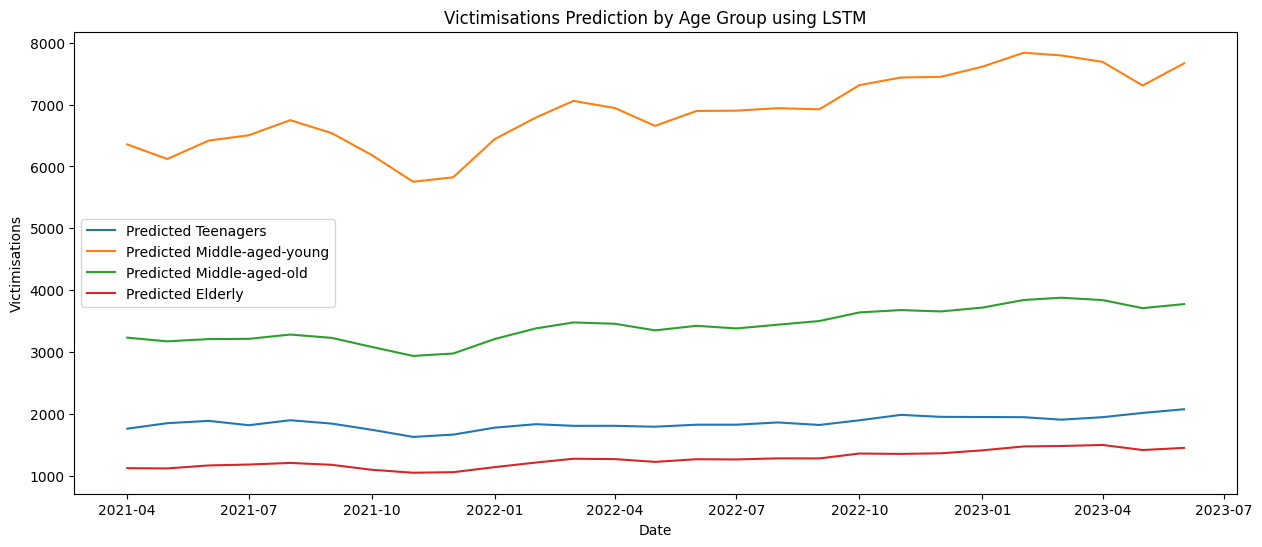

In [ ]:
from keras.callbacks import EarlyStopping

# LSTM模型训练和预测的函数
def train_and_predict_LSTM(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 加入早停回调
    early_stop = EarlyStopping(monitor='val_loss', patience=20)

    model.fit(X_train[:, :, np.newaxis], y_train, epochs=200, batch_size=4, validation_split=0.15, callbacks=[early_stop])
    predicted = model.predict(X_test[:, :, np.newaxis])
    return predicted

plt.figure(figsize=(15, 6))

# 对每一个年龄组进行训练和预测
for age_group in selected_age:
    age_data = crime_counts_by_age[crime_counts_by_age['Age Group'] == age_group]
    age_data = age_data.sort_values('Date')

    train_data = age_data[age_data['Date'] < '2021-01-01']['Victimisations'].values
    test_data = age_data[age_data['Date'] >= '2021-01-01']['Victimisations'].values

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    X_train, y_train = create_dataset(train_scaled, window_size)
    X_test, _ = create_dataset(test_scaled, window_size)  # 这里的"_"表示我们不用这个返回值

    predicted_scaled = train_and_predict_LSTM(X_train, y_train, X_test)
    predicted = scaler.inverse_transform(predicted_scaled)

    # 为预测结果创建一个时间轴
    time_axis = age_data['Date'][age_data['Date'] >= '2021-01-01'][window_size:]

    plt.plot(time_axis, predicted, label=f'Predicted {age_group}')

# 绘制图形
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction by Age Group using LSTM')
plt.legend()
plt.show()


Epoch 1/200
14/14 [==============================] - 7s 76ms/step - loss: 0.2214 - val_loss: 0.1200
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0236 - val_loss: 0.0568
Epoch 3/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0930
Epoch 4/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 0.0702
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0762
Epoch 6/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0733
Epoch 7/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0063 - val_loss: 0.0794
Epoch 8/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0060 - val_loss: 0.0674
Epoch 9/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0111 - val_loss: 0.0815
Epoch 10/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0084 - val_loss: 0.0795

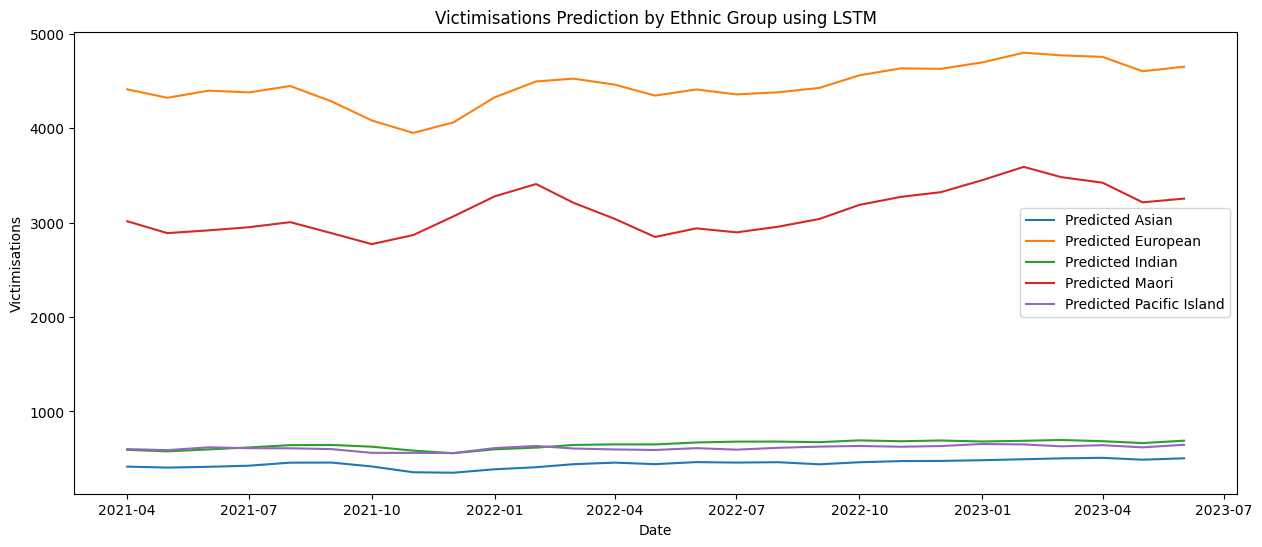

In [ ]:
plt.figure(figsize=(15, 6))
def train_and_predict_LSTM(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 加入早停回调
    early_stop = EarlyStopping(monitor='val_loss', patience=20)

    model.fit(X_train[:, :, np.newaxis], y_train, epochs=200, batch_size=4, validation_split=0.15, callbacks=[early_stop])
    predicted = model.predict(X_test[:, :, np.newaxis])
    return predicted
for ethnicity in selected_ethnicities:
    ethnic_data = crime_counts_by_ethnicity[crime_counts_by_ethnicity['Ethnic Group'] == ethnicity]
    ethnic_data = ethnic_data.sort_values('Date')

    train_data = ethnic_data[ethnic_data['Date'] < '2021-01-01']['Victimisations'].values
    test_data = ethnic_data[ethnic_data['Date'] >= '2021-01-01']['Victimisations'].values

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    X_train, y_train = create_dataset(train_scaled, window_size)
    X_test, _ = create_dataset(test_scaled, window_size)

    predicted_scaled = train_and_predict_LSTM(X_train, y_train, X_test)
    predicted = scaler.inverse_transform(predicted_scaled)

    # 为预测结果创建一个时间轴
    time_axis = ethnic_data['Date'][ethnic_data['Date'] >= '2021-01-01'][window_size:]

    plt.plot(time_axis, predicted, label=f'Predicted {ethnicity}')

# 绘制图形
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction by Ethnic Group using LSTM')
plt.legend()
plt.show()

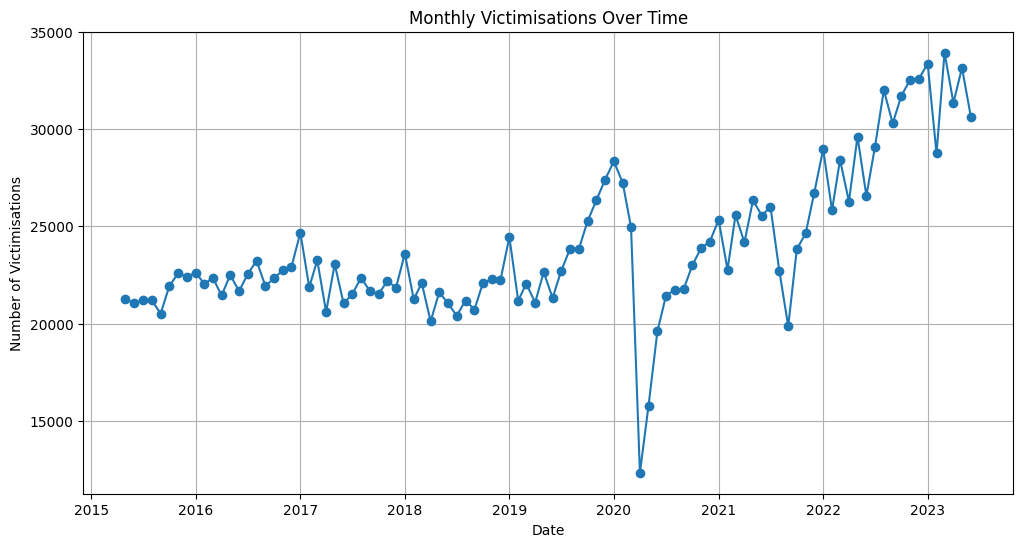

In [ ]:
###分析covid的影响。
data_covid = pd.DataFrame(grouped_data)
data_covid['Date'] = pd.to_datetime(data_covid['Date'])
plt.figure(figsize=(12, 6))
plt.plot(data_covid['Date'], data_covid['Victimisations'], marker='o')
plt.title('Monthly Victimisations Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Victimisations')
plt.grid(True)
plt.show()

In [ ]:
data_covid

,Date,Victimisations,season
0,2015-05-01,21250,2
1,2015-06-01,21045,2
2,2015-07-01,21231,3
3,2015-08-01,21211,3
4,2015-09-01,20510,0
...,...,...,...
93,2023-02-01,28750,3
94,2023-03-01,33926,2
95,2023-04-01,31354,2
96,2023-05-01,33151,2


In [ ]:
import statsmodels.api as sm
# 定义疫情前、疫情中、疫情后的标识列
data_covid['pre_covid'] = (data_covid['Date'] < "2020-03-01").astype(int)
data_covid['during_covid'] = ((data_covid['Date'] >= "2020-03-01") & (data_covid['Date'] <= "2020-06-01")).astype(int)
data_covid['post_covid'] = (data_covid['Date'] > "2020-06-01").astype(int)

# 创建交互项
data_covid['time_pre_covid'] = data_covid.index * data_covid['pre_covid']  # 假设索引作为时间
data_covid['time_during_covid'] = data_covid.index * data_covid['during_covid']
data_covid['time_post_covid'] = data_covid.index * data_covid['post_covid']

# 设定自变量和因变量
X = data_covid[['pre_covid', 'during_covid', 'post_covid', 'time_pre_covid', 'time_during_covid', 'time_post_covid']]
X = sm.add_constant(X)  # 添加截距项
y = data_covid['Victimisations']

# 使用具有 logit-link 函数的分段泊松广义线性模型
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
result = poisson_model.fit()

# 输出模型结果
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         Victimisations   No. Observations:                   98
Model:                            GLM   Df Residuals:                       92
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7869.3
Date:                Mon, 02 Oct 2023   Deviance:                       14571.
Time:                        20:53:42   Pearson chi2:                 1.43e+04
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.2871      0.04

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


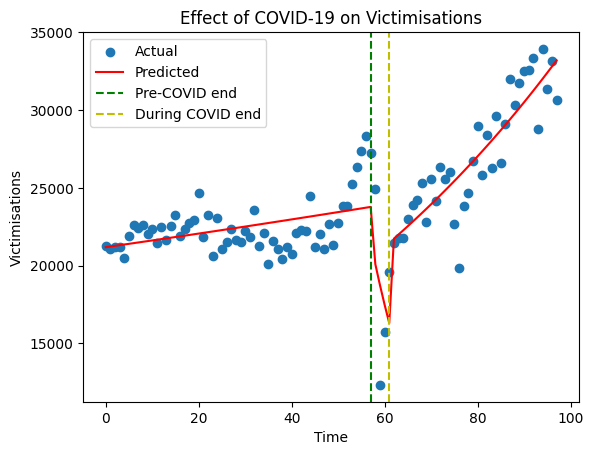

In [ ]:
# 根据模型计算预测值
data_covid['predicted'] = result.predict(X)

# 创建时间轴
time = np.arange(len(data_covid))

# 绘制实际值
plt.scatter(time, data_covid['Victimisations'], label='Actual')

# 绘制预测值
plt.plot(time, data_covid['predicted'], label='Predicted', color='red')

# 添加区分疫情前、疫情中和疫情后的竖线
pre_covid_end = data_covid[data_covid['pre_covid'] == 1].index[-1]
during_covid_end = data_covid[data_covid['during_covid'] == 1].index[-1]

plt.axvline(x=pre_covid_end, color='g', linestyle='--', label='Pre-COVID end')
plt.axvline(x=during_covid_end, color='y', linestyle='--', label='During COVID end')

# 添加图例和标签
plt.legend()
plt.xlabel('Time')
plt.ylabel('Victimisations')
plt.title('Effect of COVID-19 on Victimisations')

# 显示图表
plt.show()

In [ ]:
grouped_df = data.groupby(['Date', 'ANZSOC Division']).sum().reset_index()
final_df = grouped_df[['Date', 'ANZSOC Division', 'Victimisations']]

<ipython-input-33-a3ebafc5436e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = data.groupby(['Date', 'ANZSOC Division']).sum().reset_index()


In [ ]:

# 将 'Date' 列转为 datetime 类型
grouped_df['Date'] = pd.to_datetime(grouped_df['Date'])

# 按照犯罪类型分组
grouped = grouped_df.groupby('ANZSOC Division')

for name, group in grouped:
    print(f"Analyzing for ANZSOC Division: {name}")

    # 创建疫情前、疫情中、疫情后的标识列
    group['pre_covid'] = (group['Date'] < "2020-03-01").astype(int)
    group['during_covid'] = ((group['Date'] >= "2020-03-01") & (group['Date'] <= "2020-06-01")).astype(int)
    group['post_covid'] = (group['Date'] > "2020-06-01").astype(int)

    # 创建交互项（这里假设每一行数据是一个月，所以用月份作为时间）
    group['time_pre_covid'] = (group['Date'].dt.year - 2015) * 12 + group['Date'].dt.month
    group['time_pre_covid'] *= group['pre_covid']

    group['time_during_covid'] = (group['Date'].dt.year - 2015) * 12 + group['Date'].dt.month
    group['time_during_covid'] *= group['during_covid']

    group['time_post_covid'] = (group['Date'].dt.year - 2015) * 12 + group['Date'].dt.month
    group['time_post_covid'] *= group['post_covid']

    # 设定自变量和因变量
    X = group[['pre_covid', 'during_covid', 'post_covid', 'time_pre_covid', 'time_during_covid', 'time_post_covid']]
    X = sm.add_constant(X)
    y = group['Victimisations']

    # 使用具有 logit-link 函数的分段泊松广义线性模型
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
    result = poisson_model.fit()

    # 输出模型结果
    print(result.summary())


Analyzing for ANZSOC Division: Abduction, Harassment and Other Related Offences Against a Person
                 Generalized Linear Model Regression Results                  
Dep. Variable:         Victimisations   No. Observations:                   98
Model:                            GLM   Df Residuals:                       92
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -338.70
Date:                Mon, 02 Oct 2023   Deviance:                       151.20
Time:                        20:53:43   Pearson chi2:                     152.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3547
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The 

In [ ]:
reg_data = data.groupby("Date")["Victimisations"].sum().reset_index()
reg_data['season'] = data.groupby("Date")['season'].first().reset_index()['season']

In [ ]:
train_reg = reg_data[reg_data['Date'] < '2021-01-01']
test_reg = reg_data[reg_data['Date'] >= '2021-01-01']
scaler = MinMaxScaler()
reg_data_scaled = scaler.fit_transform(reg_data[['Victimisations', 'season']])
train_reg_scaled = reg_data_scaled[reg_data['Date'] < '2021-01-01']
test_reg_scaled =reg_data_scaled[reg_data['Date'] >= '2021-01-01']

In [ ]:
import statsmodels.api as sm
train_reg['pre_covid'] = (train_reg['Date'] < "2020-03-01").astype(int)
train_reg['during_covid'] = ((train_reg['Date'] >= "2020-03-01") & (train_reg['Date'] <= "2020-06-01")).astype(int)
train_reg['post_covid'] = (train_reg['Date'] > "2020-06-01").astype(int)

# 创建交互项
train_reg['time_pre_covid'] = train_reg.index * train_reg['pre_covid']  # 假设索引作为时间
train_reg['time_during_covid'] = train_reg.index * train_reg['during_covid']
train_reg['time_post_covid'] = train_reg.index * train_reg['post_covid']

# 设定自变量和因变量
X = train_reg[['pre_covid', 'during_covid', 'post_covid', 'time_pre_covid', 'time_during_covid', 'time_post_covid']]
X = sm.add_constant(X)  # 添加截距项
y = train_reg['Victimisations']

# 使用具有 logit-link 函数的分段泊松广义线性模型
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
result = poisson_model.fit()

# 输出模型结果
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         Victimisations   No. Observations:                   68
Model:                            GLM   Df Residuals:                       62
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5417.9
Date:                Mon, 02 Oct 2023   Deviance:                       10031.
Time:                        21:05:25   Pearson chi2:                 9.92e+03
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.0475      0.05

<ipython-input-52-01a3ebd49e31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reg['pre_covid'] = (train_reg['Date'] < "2020-03-01").astype(int)
<ipython-input-52-01a3ebd49e31>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reg['during_covid'] = ((train_reg['Date'] >= "2020-03-01") & (train_reg['Date'] <= "2020-06-01")).astype(int)
<ipython-input-52-01a3ebd49e31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [ ]:
residuals = result.resid_response
train_reg['Residuals'] = residuals

<ipython-input-53-d0e8a3ec0895>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reg['Residuals'] = residuals


In [ ]:
test_reg['pre_covid'] = (test_reg['Date'] < "2020-03-01").astype(int)
test_reg['during_covid'] = ((test_reg['Date'] >= "2020-03-01") & (test_reg['Date'] <= "2020-06-01")).astype(int)
test_reg['post_covid'] = (test_reg['Date'] > "2020-06-01").astype(int)

# 创建交互项
test_reg['time_pre_covid'] = test_reg.index * test_reg['pre_covid']  # 假设索引作为时间
test_reg['time_during_covid'] = test_reg.index * test_reg['during_covid']
test_reg['time_post_covid'] = test_reg.index * test_reg['post_covid']

# 设定自变量和因变量
X = test_reg[['pre_covid', 'during_covid', 'post_covid', 'time_pre_covid', 'time_during_covid', 'time_post_covid']]
X = sm.add_constant(X)  # 添加截距项



<ipython-input-55-383fa837e27b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_reg['pre_covid'] = (test_reg['Date'] < "2020-03-01").astype(int)
<ipython-input-55-383fa837e27b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_reg['during_covid'] = ((test_reg['Date'] >= "2020-03-01") & (test_reg['Date'] <= "2020-06-01")).astype(int)
<ipython-input-55-383fa837e27b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import pandas as pd

# 假设data是您原始的DataFrame
# reg_data = data.groupby("Date")["Victimisations"].sum().reset_index()
# reg_data['season'] = data.groupby("Date")['season'].first().reset_index()['season']

# 创建训练和测试数据
train_reg = reg_data[reg_data['Date'] < '2021-01-01'].copy()
test_reg = reg_data[reg_data['Date'] >= '2021-01-01'].copy()

# 数据缩放
scaler = MinMaxScaler()
reg_data_scaled = scaler.fit_transform(reg_data[['Victimisations', 'season']])
train_reg_scaled = reg_data_scaled[reg_data['Date'] < '2021-01-01']
test_reg_scaled = reg_data_scaled[reg_data['Date'] >= '2021-01-01']

# 添加COVID相关的列
train_reg['pre_covid'] = (train_reg['Date'] < "2020-03-01").astype(int)
train_reg['during_covid'] = ((train_reg['Date'] >= "2020-03-01") & (train_reg['Date'] <= "2020-06-01")).astype(int)
train_reg['post_covid'] = (train_reg['Date'] > "2020-06-01").astype(int)

# 创建交互项
train_reg['time_pre_covid'] = train_reg.index * train_reg['pre_covid']
train_reg['time_during_covid'] = train_reg.index * train_reg['during_covid']
train_reg['time_post_covid'] = train_reg.index * train_reg['post_covid']

# 设定自变量和因变量
X_train = train_reg[['pre_covid', 'during_covid', 'post_covid', 'time_pre_covid', 'time_during_covid', 'time_post_covid']]
X_train = sm.add_constant(X_train)  # 添加截距项
y_train = train_reg['Victimisations']

# 使用泊松广义线性模型
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson(link=sm.families.links.log()))
result = poisson_model.fit()

# 输出模型结果
print(result.summary())

# 预测和测试
test_reg['pre_covid'] = (test_reg['Date'] < "2020-03-01").astype(int)
test_reg['during_covid'] = ((test_reg['Date'] >= "2020-03-01") & (test_reg['Date'] <= "2020-06-01")).astype(int)
test_reg['post_covid'] = (test_reg['Date'] > "2020-06-01").astype(int)

# 创建交互项
test_reg['time_pre_covid'] = test_reg.index * test_reg['pre_covid']
test_reg['time_during_covid'] = test_reg.index * test_reg['during_covid']
test_reg['time_post_covid'] = test_reg.index * test_reg['post_covid']

# 设定测试数据的自变量
X_test = test_reg[['pre_covid', 'during_covid', 'post_covid', 'time_pre_covid', 'time_during_covid', 'time_post_covid']]
X_test['const'] = 1.0  # 添加截距项

# 使用模型进行预测
reg_pred_test = result.predict(X_test)


                 Generalized Linear Model Regression Results                  
Dep. Variable:         Victimisations   No. Observations:                   68
Model:                            GLM   Df Residuals:                       62
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5417.9
Date:                Mon, 02 Oct 2023   Deviance:                       10031.
Time:                        21:11:32   Pearson chi2:                 9.92e+03
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.0475      0.05

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


ValueError: ignored

In [ ]:
scaler = MinMaxScaler()
residuals = np.array(residuals).reshape(-1, 1)
residuals_scaled = scaler.fit_transform(residuals)

In [ ]:
residuals

0      62.247470
1    -185.621218
2     -42.576640
3    -105.618973
4    -849.748393
         ...    
63      1.566644
64   -563.403569
65     32.186620
66    296.885249
67    -31.772072
Length: 68, dtype: float64

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# 创建训练数据
window_size = 3
X_train_res, y_train_res = create_dataset(residuals_scaled, window_size)
X_train_res = np.reshape(X_train_res, (X_train_res.shape[0], X_train_res.shape[1], 1))

# 创建 LSTM 模型
model_res = Sequential()
model_res.add(LSTM(200, return_sequences=True, input_shape=(window_size, 1)))
model_res.add(LSTM(150))
model_res.add(Dropout(0.1))
model_res.add(Dense(1))

# 编译和训练模型
model_res.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='loss', patience=20)
history_res = model_res.fit(X_train_res, y_train_res, epochs=200, batch_size=4, callbacks=[early_stop])

Epoch 1/200
17/17 [==============================] - 4s 14ms/step - loss: 0.1125
Epoch 2/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0256
Epoch 3/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0278
Epoch 4/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0254
Epoch 5/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0246
Epoch 6/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0320
Epoch 7/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0267
Epoch 8/200
17/17 [==============================] - 0s 13ms/step - loss: 0.0266
Epoch 9/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0278
Epoch 10/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0282
Epoch 11/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0259
Epoch 12/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0348
Epoch 13/200
17/17 [=====

In [ ]:
X_test_res, _ = create_dataset(test_reg_scaled, window_size)
X_test_res = np.reshape(X_test_res, (X_test_res.shape[0], X_test_res.shape[1], 1))
lstm_pred = model_res.predict(X_test_res)
lstm_pred = scaler.inverse_transform(lstm_pred)

1/1 [==============================] - 3s 3s/step


In [ ]:
lstm_pred

array([[-171.02795 ],
       [-242.30925 ],
       [ -21.516518],
       [ -23.862778],
       [  82.40229 ],
       [-152.73451 ],
       [-517.0371  ],
       [-626.47815 ],
       [-492.73065 ],
       [ -68.8257  ],
       [ 249.42842 ],
       [ 293.04736 ],
       [ 403.5592  ],
       [ 240.62541 ],
       [ 476.46576 ],
       [ 353.3056  ],
       [ 524.6584  ],
       [ 688.87573 ],
       [ 877.62036 ],
       [1026.4135  ],
       [1066.3523  ],
       [1185.8759  ],
       [1279.7249  ],
       [1035.5972  ],
       [1153.6888  ],
       [1031.6068  ],
       [1272.4545  ]], dtype=float32)

In [ ]:
# 对齐预测结果的长度
min_length = min(len(reg_pred_test), len(lstm_pred))
aligned_reg_pred = reg_pred_test[:min_length]
aligned_lstm_pred = lstm_pred[:min_length]
aligned_reg_pred = aligned_reg_pred.squeeze()
aligned_lstm_pred = aligned_lstm_pred.squeeze()

# 叠加预测结果
combined_pred = aligned_reg_pred + aligned_lstm_pred


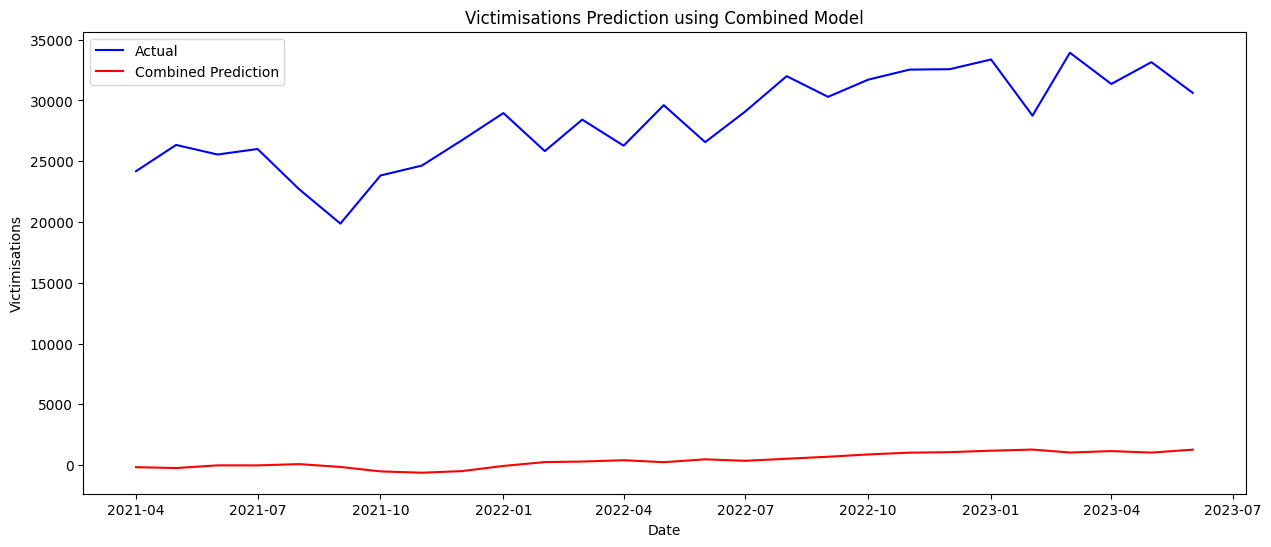

In [ ]:
# 确保时间轴、实际值和 combined_pred 的长度相同
min_length = min(len(time_axis), len(y_test_transformed), len(combined_pred))
time_axis = time_axis[:min_length]
y_test_transformed = y_test_transformed[:min_length]
combined_pred = combined_pred[:min_length]

# 创建图表
plt.figure(figsize=(15, 6))

# 绘制实际数据
plt.plot(time_axis, y_test_transformed, label='Actual', color='blue')

# 绘制综合预测数据（这里假设是 combined_pred）
plt.plot(time_axis, combined_pred, label='Combined Prediction', color='red')

# 添加图例和标签
plt.legend()
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction using Combined Model')

# 显示图表
plt.show()

